# 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 2. Load Dataset 

In [13]:
import os
print(os.getcwd())

C:\Users\user


In [15]:
import os
print(os.listdir())

['.android', '.arduinoIDE', '.bash_history', '.cache', '.conda', '.condarc', '.config', '.continuum', '.gitconfig', '.gradle', '.idlerc', '.ipynb_checkpoints', '.ipython', '.jupyter', '.lesshst', '.m2', '.matplotlib', '.ms-ad', '.node_repl_history', '.redhat', '.rest-client', '.spyder-py3', '.streamlit', '.VirtualBox', '.vscode', 'anaconda3', 'AndroidStudioProjects', 'AppData', 'Application Data', 'armstrongnumber.c', 'armstrongnumber.exe', 'asciistring.c', 'c program', 'c program.txt', 'compstring.c', 'compstring.exe', 'Contacts', 'Cookies', 'Desktop', 'Documents', 'Downloads', 'duplicateentriesofarray.c', 'duplicateentriesofarray.exe', 'ETL_Movie.ipynb', 'Favorites', 'hello.c', 'hello.exe', 'html tutorial', 'html.code-workspace', 'IdeaProjects', 'index.html', 'IntelGraphicsProfiles', 'Links', 'Local Settings', 'Movie Recommendation System.ipynb', 'movielens', 'Music', 'My Documents', 'NetHood', 'new,py', 'NTUSER.DAT', 'ntuser.dat.LOG1', 'ntuser.dat.LOG2', 'NTUSER.DAT{b3fe01ca-d8f6-11

In [16]:
ratings = pd.read_csv("movielens/ml-latest-small/ratings.csv")
movies = pd.read_csv("movielens/ml-latest-small/movies.csv")

print(ratings.head())
print(movies.head())

   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


# 3. Data Cleaning

In [17]:
print("Missing values:", ratings.isnull().sum().sum() + movies.isnull().sum().sum())

Missing values: 0


In [19]:
# Merge datasets
df = ratings.merge(movies, on="movieId")
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


# 4. Exploratory Data Analysis (EDA)

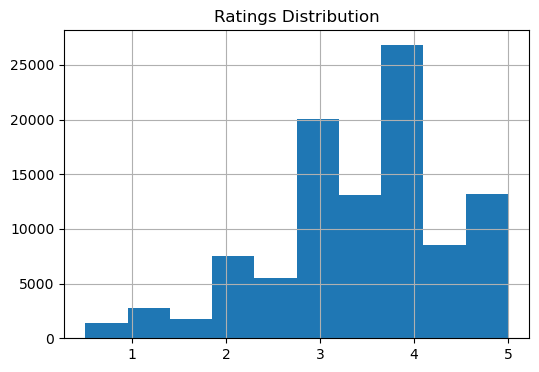

In [20]:
plt.figure(figsize=(6,4))
ratings['rating'].hist(bins=10)
plt.title("Ratings Distribution")
plt.show()

<Axes: title={'center': 'Most Rated Movies'}, ylabel='title'>

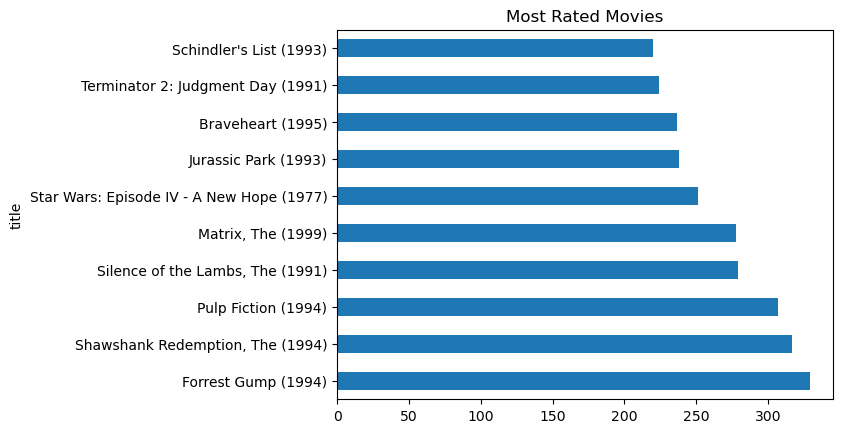

In [21]:
top_movies = df.groupby("title")['rating'].count().sort_values(ascending=False).head(10)
top_movies.plot(kind='barh', title="Most Rated Movies")

# 5. Collaborative Filtering

In [22]:
# 5.1 User-Item Matrix
user_item_matrix = ratings.pivot(index='userId', columns='movieId', values='rating').fillna(0)

In [23]:
# 5.2 User-User Similarity
user_sim = cosine_similarity(user_item_matrix)
print("User-User similarity matrix shape:", user_sim.shape)

User-User similarity matrix shape: (610, 610)


In [24]:
# 5.3 Matrix Factorization (NMF)
nmf = NMF(n_components=20, random_state=42)
W = nmf.fit_transform(user_item_matrix)
H = nmf.components_
pred = np.dot(W, H)

rmse = mean_squared_error(user_item_matrix, pred, squared=False)
print("NMF RMSE:", rmse)

C:\Anaconda DS\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Anaconda DS\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


NMF RMSE: 0.2555008947821109


# 6. Content-Based Filtering

In [25]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies['genres'])

cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

def recommend_content(movie_title, top_n=5):
    idx = movies[movies['title'] == movie_title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    movie_indices = [i[0] for i in sim_scores]
    return movies['title'].iloc[movie_indices]

print(recommend_content("Toy Story (1995)"))

1706                                       Antz (1998)
2355                                Toy Story 2 (1999)
2809    Adventures of Rocky and Bullwinkle, The (2000)
3000                  Emperor's New Groove, The (2000)
3568                             Monsters, Inc. (2001)
Name: title, dtype: object


# 7. Hybrid Recommendation

In [26]:
def hybrid_recommend(user_id, top_n=5):
    # Get NMF predictions for this user
    user_idx = user_id - 1
    user_ratings = pred[user_idx]
    
    # Rank top movies by predicted score
    top_indices = np.argsort(user_ratings)[::-1][:top_n]
    
    return movies[movies['movieId'].isin(user_item_matrix.columns[top_indices])]['title']

print("Hybrid Recommendations for User 1:")
print(hybrid_recommend(1))

Hybrid Recommendations for User 1:
224            Star Wars: Episode IV - A New Hope (1977)
507                    Terminator 2: Judgment Day (1991)
898    Star Wars: Episode V - The Empire Strikes Back...
900    Raiders of the Lost Ark (Indiana Jones and the...
911    Star Wars: Episode VI - Return of the Jedi (1983)
Name: title, dtype: object


# 8. Evaluation

In [30]:
# 8.1 Mean Absolute Error 
mae = mean_absolute_error(user_item_matrix, pred)
print("MAE:", mae)

MAE: 0.0804288260235261


In [31]:
# 8.2 Extended with Precision@K
def precision_at_k(pred_matrix, true_matrix, k=5, threshold=4.0):
    """
    Compute Precision@K for recommendations
    pred_matrix: predicted ratings (numpy array)
    true_matrix: actual ratings (numpy array)
    k: top-k items to consider
    threshold: rating threshold to consider as relevant
    """
    precisions = []
    
    for user_idx in range(true_matrix.shape[0]):
        # Skip users with no ratings
        if np.count_nonzero(true_matrix[user_idx]) == 0:
            continue
        
        # Top-K predictions
        top_k_pred_items = np.argsort(pred_matrix[user_idx])[::-1][:k]
        
        # Relevant items (actual rating >= threshold)
        relevant_items = np.where(true_matrix[user_idx] >= threshold)[0]
        
        if len(relevant_items) == 0:
            continue
        
        hits = len(set(top_k_pred_items) & set(relevant_items))
        precisions.append(hits / k)
    
    return np.mean(precisions)

In [32]:
# Convert matrix to numpy for evaluation
true_matrix = user_item_matrix.to_numpy()

In [39]:
# --- NMF Evaluation --- 
rmse_nmf = mean_squared_error(true_matrix, pred, squared=False)
mae_nmf = mean_absolute_error(true_matrix, pred)
p5_nmf = precision_at_k(pred, true_matrix, k=5)
p10_nmf = precision_at_k(pred, true_matrix, k=10)

C:\Anaconda DS\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [40]:
# --- User-based CF Evaluation ---
user_pred = user_sim.dot(user_item_matrix) / np.array([np.abs(user_sim).sum(axis=1)]).T
user_pred = np.array(user_pred)

rmse_user = mean_squared_error(true_matrix, user_pred, squared=False)
mae_user = mean_absolute_error(true_matrix, user_pred)
p5_user = precision_at_k(user_pred, true_matrix, k=5)
p10_user = precision_at_k(user_pred, true_matrix, k=10)

C:\Anaconda DS\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [41]:
# --- Item-based CF Evaluation ---
item_sim = cosine_similarity(user_item_matrix.T)
item_pred = user_item_matrix.dot(item_sim) / np.array([np.abs(item_sim).sum(axis=1)])
item_pred = item_pred.to_numpy()

rmse_item = mean_squared_error(true_matrix, item_pred, squared=False)
mae_item = mean_absolute_error(true_matrix, item_pred)
p5_item = precision_at_k(item_pred, true_matrix, k=5)
p10_item = precision_at_k(item_pred, true_matrix, k=10)

C:\Anaconda DS\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [42]:
# --- Summary Table ---
results = pd.DataFrame({
    "Model": ["NMF", "User-based CF", "Item-based CF"],
    "RMSE": [rmse_nmf, rmse_user, rmse_item],
    "MAE": [mae_nmf, mae_user, mae_item],
    "Precision@5": [p5_nmf, p5_user, p5_item],
    "Precision@10": [p10_nmf, p10_user, p10_item]
})

print("\nEvaluation Results:")
print(results)


Evaluation Results:
           Model      RMSE       MAE  Precision@5  Precision@10
0            NMF  0.255501  0.080429     0.536289      0.492939
1  User-based CF  0.324236  0.116136     0.514943      0.489819
2  Item-based CF  0.331362  0.139706     0.163218      0.121839


# 9. Visualization of Recommendations

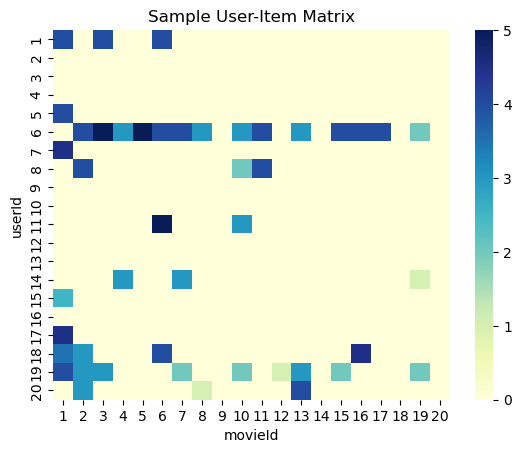

In [29]:
sns.heatmap(user_item_matrix.iloc[:20, :20], cmap="YlGnBu")
plt.title("Sample User-Item Matrix")
plt.show()